In [1]:
import numpy as np
import scipy.linalg as sp
import torch as th

import os, pdb, sys, json, glob, tqdm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from itertools import product

sns.set_style('whitegrid')

sns.set_context('notebook')

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 200

%load_ext autoreload
%autoreload 2

dev = 'cuda'
from utils import *

In [2]:
def get_idx(dd, cond):
    return dd.query(cond).index.tolist()

def drop_untrained(dd, th=0.01, verbose=False):
    tmax = dd['t'].max()
    ii = get_idx(dd, f"t == {tmax} & err > {th}")
    iis = [j for i in ii for j in range(i-tmax, i+1, 1)]
    if verbose:
        print(len(ii))
        print(dd[['m', 'opt', 'bn', 'seed']].iloc[ii])
    return dd.drop(iis)

In [3]:
def avg_model(d, groupby=['m', 't'], avg=None, get_err=True, compute_distance=False, dev='cuda'):
    key = ['yh', 'yvh']
    n_data = d[key].iloc[0].shape[0]
    
    if not avg:
        avg = {}
        for k in key:
            d[k] = d.apply(lambda r: np.exp(r[k].flatten().numpy()), axis=1)

        avg = d.groupby(groupby)[key].mean(numeric_only=False).reset_index()
    
    if get_err:
        for k in key:
            ykey = k.strip("h")
            y = get_data(dev='cuda')[ykey]
            n = len(y)
            preds = np.argmax(np.stack(avg[k]).reshape(-1, n , 10), -1)
            err =  ((th.Tensor(preds).cuda() == y).sum(1) / n).cpu().numpy()
            avg[f'{ykey[1:]}err'] = err
    
    if compute_distance:
        dists = []
        for i in range(len(avg)):
            config = {}
            for k in groupby:
                v = avg.iloc[i][k]
                if isinstance(v, str):
                    v = f"'{v}'"
                config[k] = v
            ii = get_idx(d, "&".join([f"{k} == {v}" for (k, v) in config.items()]))
            
            for k in key:
                x1 = avg.iloc[i][k].reshape(-1, 1, 10)
                x2 = np.stack(d.loc[ii][k]).reshape(-1, len(ii), 10)
                x1 = th.sqrt(th.Tensor(x1)).to(dev)
                x2 = th.sqrt(th.Tensor(x2)).to(dev)

                dist = -th.log(th.bmm(x2, x1.transpose(1,2))).sum(0)

                for (j, dj) in enumerate(dist):
                    dic = dict(dist=dj.item(), key=k)
                    dic.update(config)
                    dists.append(dic)
        dists = pd.DataFrame(dists)
        return avg, dists
    return avg

In [10]:
loc = 'results/models/new'
# d = pd.read_pickle(os.path.join(loc, "avg_models.pkl"))
d = load_d(loc, cond={'bs':200, 'aug':True, 'wd':0.0})
# d_ = drop_untrained(d, 0.01, False)
# del d

Index(['seed', 'm', 'opt', 'lr', 'wd', 'bn', 'aug', 'bs', 't', 'yh', 'f', 'e',
       'yvh', 'fv', 'ev', 'err', 'verr', 'favg', 'vfavg'],
      dtype='object') 3600


<AxesSubplot:xlabel='t', ylabel='dist'>

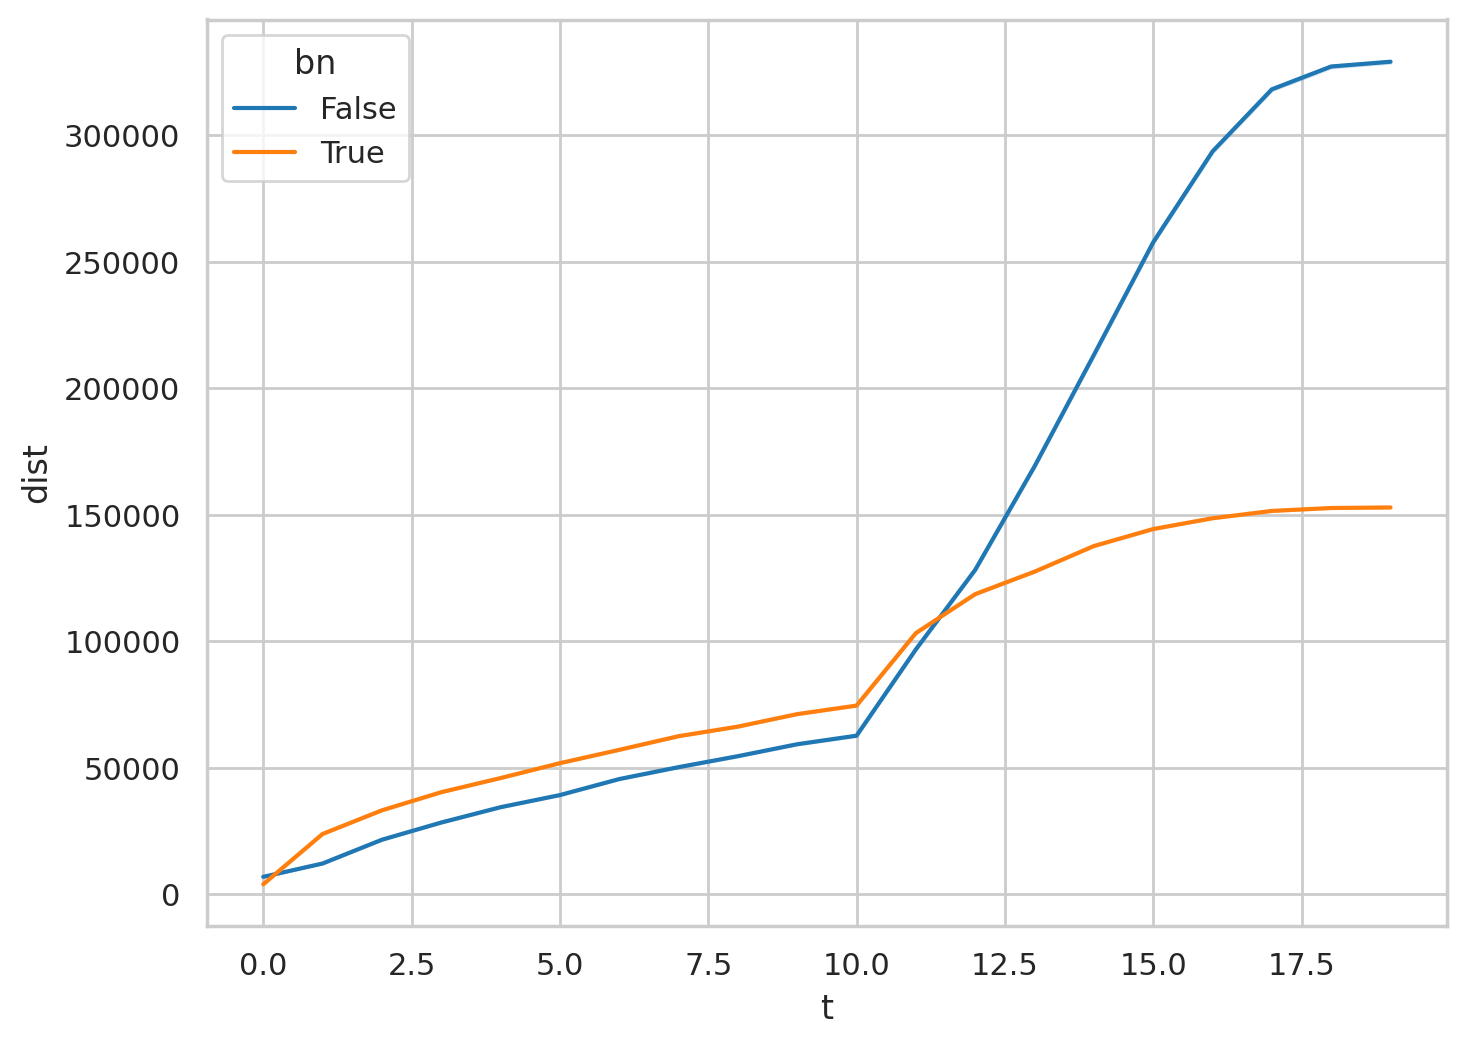

In [7]:
sns.lineplot(data=dists.iloc[get_idx(dists, "key == 'yh'")], x='t', y='dist', hue='bn')